# 0. Introduction

## 0.1 Readings

A good resource for today's task (besides the assigned readings from last week) is the following tutorial: [Word2Vec Tutorial: The SkipGram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). Part 2 provides a really good overview of negative sampling!

## 0.2 Task

This week your tasks will be:
1. Train a CBOW model with a real world dataset, explore how the parameters affect the model.
2. Learn how to evaluate an embedding, through intrinsic and extrinsic evaluation.
2. Build a SkipGram model, based on your experience on CBOW.


# 1. CBOW


Our first task is to build our very own CBOW. In this section, you will *NOT* be required to write code for the network. Instead, you will be exploring the model by forming a hypothesis and testing it through different parameter settings.

First, let's remind ourselves of the famous quote:

> You shall know a word by the company it keeps (Firth, J. R. 1957:11)

What this implies is that it is possible to define a word, or *meaning* of a word in a way that describes a prediction task: **the task of predicting the word given the context**. However, one problem still remains: how to represent the meaning of a word? Luckily, there has already been a line of works that suggest a solution: representing the meaning of a word by a vector -- the vector space model.

Now let's imagine that we are given a near-perfect vector space model that maps meaning of a word to vector. One of the easiest ways to solve the task then, is that we can literally just use the sum of the context vectors as the inputs, the target word vector as the output, and fit it through a linear model!

And that is exactly what CBOW is doing: <img src="figures/cbow.png" alt="cobw" style="width: 400px;"/>

The weights between the input and hidden layer are the vector space model mapping, and the weights between the hidden and output layer are the linear prediction model. 

The only catch is that we don't have that near-perfect vector space model given to us! Thus, our goal is to jointly learn (1) a representation of the word, and (2) a prediction model. In the following sections, we will explore how to do that through PyTorch.



## 1.1 Building our training set

We want to start with building a training set. For the purpose of this exploratory exercise, you will be using a medium size corpus: the [IMDB movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) (you should already downloaded it in `README.md`)


### Data Preprocessing

First, we removed all punctuations and lowercased everything, and tokenize it by whitespace.

In [2]:
# A utility collections for data processing, make sure you already download the data(see README.md)
from utils import read_imdb_data

# read_imdb_data removes punctuations and lowercase everything
X_raw_train, y_train = read_imdb_data('../data/aclImdb/train')
raw_text = ' '.join(X_raw_train).split()

To make sure that it is properly loaded, let's peek into the content a bit:

In [3]:
print(' '.join(raw_text[:30]))

story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a formal orchestra audience is


### Filter the Vocab

For the purpose of this assignment, and for the sake of training time, we limit the vocabulary to the most common 1000 words.

In [4]:
from collections import Counter

# pick the top words only
raw_text_count = Counter(raw_text)
vocab = set(list(zip(*raw_text_count.most_common(1000)))[0])
vocab_size = len(vocab)

We then only keep the selected words in the raw text.

In [5]:
# filter raw text by vocab
text = [r for r in raw_text if r in vocab]

---
# Question 1

The preprocessing steps introduced here seem very naive, and potentially problematic. Before you read further down the exercise, based on your understanding of CBOW, 

1. list three potential concerns with the preprocessing choices, explain why they might be a concern.
2. potential fixes for these concerns.
---

### Building the Dataset

Now let's build our dataset! First we define some handy helper functions:

In [6]:
def make_context_vector(context, word_to_ix):
    '''
    helper function to translate context into indexes for inputs
    In:
        context: a list of words
        word_to_ix: a mapping from word to index
    Out:
        idxs: a list of indexes
    '''
    idxs = [word_to_ix[w] for w in context]
    return idxs

In [7]:
def data_batcher(X, Y, batches=5):
    '''
    helper function to batch data, note that batches is not the size of the batch, 
    but how many batches the dataset is divided into.
    In:
        X: a matrix of size (num_sample, CONTEXT_SIZE*2)
        Y: an array of size (num_sample)
        batches: how many batches the dataset is divided into, default:5
    Out:
        a batch of X and Y
    '''
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    for i in range(batches):
        start = int((i * X.shape[0]) / batches)
        end = int(((i + 1) * X.shape[0]) / batches)
        yield X[start:end, :], Y[start:end]

Recall that our given (X) is the context, our target (Y) is the word. 

We then build our dataset by iterating through the filtered text and mapping the words to indexes.

In [8]:
import numpy as np

# Let's set the context window size to 2 for now
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right

# A mapping from word to index
word_to_ix = {word: i for i, word in enumerate(vocab)}

X = []
Y = []
# iterate through the text to build dataset
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    context = [text[i + j] for j in range(-CONTEXT_SIZE, CONTEXT_SIZE+1) if not j==0]
    target = text[i]
    # the data translate to indexes, X is the context, Y is the target word.
    X.append(make_context_vector(context, word_to_ix))
    Y.append(word_to_ix[target])

# convert to numpy for easier data handling later
X = np.array(X, dtype=int)
Y = np.array(Y, dtype=int)

## 1.2 CBOW with PyTorch

Now that we have our dataset built, let's import PyTorch!

Note: if importing PyTorch failed, first try to click on Kernel->Change Kernel->Python \[conda env:pytorch_w2v\] on the upper bar of the notebook. It is likely that you did not set the kernel (which is what the jupyter notebook is running on) to the one you had pytorch installed. If you change the kernel, please re-run this jupyter notebook.

In [9]:
# import PyTorch
import torch
# torch.nn contains modules or subcomponents of the network required to train the network.
import torch.nn as nn
# torch.nn.functional is a collection of handy functions that you can build into the model
import torch.nn.functional as F
# torch.optim contains optimizers to update the parameters of network
import torch.optim as optim

"""
Variable in torch.autograd is used to tell pytorch that 
the object should be put into the PyTorch computation graph. 
See readings for more details.
"""
from torch.autograd import Variable

Now, let's look at two modules of pytorch that will be especially useful for our implementation of CBOW: `nn.Embedding` and `nn.Linear`

In [10]:
print(nn.Embedding.__doc__)

A simple lookup table that stores embeddings of a fixed dictionary and size.

    This module is often used to store word embeddings and retrieve them using indices.
    The input to the module is a list of indices, and the output is the corresponding
    word embeddings.

    Args:
        num_embeddings (int): size of the dictionary of embeddings
        embedding_dim (int): the size of each embedding vector
        padding_idx (int, optional): If given, pads the output with zeros whenever it encounters the index.
        max_norm (float, optional): If given, will renormalize the embeddings to always have a norm lesser than this
        norm_type (float, optional): The p of the p-norm to compute for the max_norm option
        scale_grad_by_freq (boolean, optional): if given, this will scale gradients by the frequency of
                                                the words in the mini-batch.
        sparse (boolean, optional): if ``True``, gradient w.r.t. weight matrix will be a

In [11]:
print(nn.Linear.__doc__)

Applies a linear transformation to the incoming data: :math:`y = Ax + b`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, in\_features)` where `*` means any number of
          additional dimensions
        - Output: :math:`(N, *, out\_features)` where all but the last dimension
          are the same shape as the input.

    Attributes:
        weight: the learnable weights of the module of shape
            (out_features x in_features)
        bias:   the learnable bias of the module of shape (out_features)

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = autograd.Variable(torch.randn(128, 20))
        >>> output = m(input)
        >>> print(output.size())
    


### The CBOW model

Now, it's the exciting part. Let's build our model!

Recall that network structure of CBOW is equivalent to $A\left ( \sum_{w \in Context} q_w \right ) + b$, where $q_w$ is the vector representation of word $w$, A and b are parameters for the linear prediction model. If we applied log softmax to convert the output to log probability, our goal then becomes: 

$$arg\max_{A, b, Q} \log P(w_i|Context) = arg\max_{A, b, Q} logSoftmax\left (A\left ( \sum_{w \in Context} q_w \right ) + b\right )$$

where $Q$ is the matrix of embeddings.

With this in mind, our model is thus:

In [12]:
class CBOW(nn.Module):
    """
    A PyTorch implementation of CBOW for exploratory purpose.
    
    Args:
        - vocab_size: size of the vocabulary
        - embedding_dim: dimension of the representation vector for words
        - word_to_ix: a mapping from word to index
    
    Shape:
        - Input: LongTensor (N, W), N = mini-batch size, W = number of indices to extract per mini-batch
        - Output: (N, vocab_size),  N = mini-batch size
    
    """

    # Initializing the model, instanciating the required module (Not linking them)
    def __init__(self, vocab_size, embedding_dim, word_to_ix):
        # A standard python way of saying CBOW is going to inherit nn.Module
        super(CBOW, self).__init__()
        
        self.word_to_ix = word_to_ix
        
        """
        We create an nn.Embedding instance with vocab size and embedding dimension specified.
        sparse=True enable sparse gradient updates, which speed up the computation and save memory.
        """
        self.emb = nn.Embedding(vocab_size, embedding_dim, sparse=True)
       
        """
        We create an nn.Linear instance with embedding_dim as the input features size
        and vocab_size as the output size. Recall that the goal of nn.Linear is
        a prediction model which maps from an embedding to scores over the vocabulary space.
        """
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
        """
        We create an nn.LogSoftmax instance that convert scores to log probility over dim=1, 
        as we are using dim=0 as the mini-batch dimension.
        """
        self.logsoftmax = nn.LogSoftmax(dim=1)

    # Here is where we acutally link the modules to describe how the data flow through the network.
    def forward(self, inputs):
        """
        - inputs: LongTensor (N, W), N = mini-batch size, W = number of indices to extract per mini-batch
        - outputs: (N, vocab_size),  N = mini-batch size
        """
        out = self.emb(inputs).sum(dim=1)
        out = self.linear(out)
        return self.logsoftmax(out)

    # helper function to retrieve the trained vector space model (or word embedding)
    def word_embedding(self):
        return model.emb.weight
    
    # helper function to do a word to vector lookup
    def word2vec(self, word):
        return model.emb.weight[self.word_to_ix[word], :]

Note that there really wasn't many lines of code! Most of those are acutally my comments!


### Training

Next we need to actually train the model.

In [13]:
# handy library to help you visualize the progress
import progressbar

"""
A function to call for training given the model.

Parameters for train():
    - model: a CBOW instance
    - num_epochs: number of time the entire dataset is trained through
    - batches:  recall that batches is not the size of the batch, 
                but how many batches the dataset is divided into.
"""
def train(model, num_epochs=5, batches=100):
    
    """
    The negative log likelihood loss. 
    It is useful to train a classification problem with C classes.
    Expected to contain log-probabilities of each class. See nn.NLLLoss.__doc__ for more details.
    """
    criterion = nn.NLLLoss()
    
    """
    The stochastic gradient descent optimizer used to update weights, once gradient is computed.
    We set a learning rate of 0.001, and momentum of 0.9.
    """
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # keep track of the loss of the model to see if the model converges.
    losses = []
    
    for epoch in range(num_epochs):
        
        # progressbar setting
        widgets = ['Epoch {} '.format(epoch), progressbar.Percentage(), ' ', progressbar.Bar(), ' ', progressbar.ETA()]
        bar = progressbar.ProgressBar(widgets=widgets, max_value=batches)

        for context, target in bar(data_batcher(X, Y, batches)):
            """
            Wrap our training pair context and target first through torch.LongTensor, 
            and then through Variable.
            
            torch.LongTensor is a holder for integer variable, and is expected by the model as input.
            
            Variable is used to put x and y into the PyTorch computation graph. See readings for more details.
            """
            x = Variable(torch.LongTensor(context))
            y = Variable(torch.LongTensor(target))
            
            """
            zero the parameter gradients
        
            If you don't do so, the gradients will accumulate and lead to significant slow down.
            """
            optimizer.zero_grad()

            """
            forward
            
            The final piece how connecting the network to the data! 
            We feed the data in, and get a loss value back.
            """
            outputs = model(x)
            loss = criterion(outputs, y)
            
            """
            backward
            
            This may seem like black magic, but what it really does is 
            essentially doing chain rule (or a fancier term -- backpropagation)
            
            Intuitively, for every object x that is a Variable, this calculates
            
            d loss
            -------
            d x
            
            And exactly how to break down the above term to get the actual gradient?
            This is done automatically by the computation graph PyTorch build while 
            you write the model! Thus the name 'autograd'.
            """
            loss.backward()
            
            """
            optimize
            
            Now that for every Variable, we have calculate the gradient, we can use an
            optimizer to update the weights!
            
            SGD for example, does something intuitively like this:
            w = w + learning_rate*w.grad
            """
            optimizer.step()
            
            # just to record the loss
            losses.append(loss.data.numpy())
    return losses

Let's start training!

In [14]:
# import matplotlib to plot the losses
from matplotlib import pyplot as plt

Epoch 0 100% |##################################################| Time: 0:03:17
Epoch 1 100% |##################################################| Time: 0:03:08
Epoch 2 100% |##################################################| Time: 0:03:11


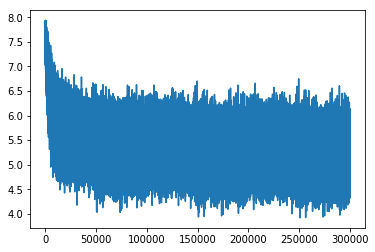

In [15]:
"""
We first initalize a CBOW model of vocab_size 1000 (the top 1000 words we limited it to)
and train a vector space model with embbeding dimension=10, since we only have a medium dataset.
"""
model = CBOW(vocab_size, 10, word_to_ix)

# Train with 3 epochs, 100,000 data batches
plt.plot(train(model, 3, 100000))

# TODO

### This part will be converted to an evaluation part

Now let's quickly check our results!

In [16]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
cos(model.word2vec('movie'), model.word2vec('film'))

Variable containing:
 0.8933
[torch.FloatTensor of size 1]

In [17]:
def closest_n_words(model, vocab, word, n=10):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    word_vec = model.word2vec(word)
    scores=[]
    for v in vocab:
        if not v == word:
            score = cos(model.word2vec(v), word_vec)
            scores.append((score, v))
    return list(zip(*(sorted(scores, key=lambda score: score[0].data.numpy(), reverse=True)[:n])))[1]

In [18]:
closest_n_words(model, vocab, 'movie')

('film', 'fans', 'as', 'wish', 'wait', 'since', 'roles', 'hate', 'much', 'lee')

---
# Question 2

Now that you learned how to evaluate a vector space model, let's explore the model by changing the parameters!

Form **two hypothesis** of how the parameters may affect the model. For each of the hypothesis, do some experiments to prove or disprove your point! Describe the two hypothesis, your experiments, rationale, and results (if any), in the writeup. Don't include code for this part unless nessasary.

Also, the definition of parameters are very broad: anything outside of the CBOW model can be considered parameters, including the preprocessing part!

Note that you may not be able to sucessfully test the assumption, either due to long training time or lack of training data. The key to the grading will be whether the assumptions are grounded in what we learned in class, and whether the experiments, if sucessfuly ran, would logically support/deny your assumptions.

We are also not concerned with whether your performance of embedding beats state-of-the-art, as that is not the purpose of this exploratory assignment.

---

# 2. Skipgrams

The second task is to train a SkipGram model. Take inspiration from the CBoW classifier trained in the slides, but remember the implementational differences in skipgram.

For one, you generally think about it as having 2 embedding matrices, a word-embedding and a context-embedding. Secondly, you're predicting the context from the words, not the other way around. That part won't change your model code, but it will change how you preprocess the data.

In [6]:
X = '''
it was the best of times it was the worst of times 
it was the age of wisdom it was the age of foolishness
it was the epoch of belief it was the epoch of credulity
'''.split()

# You'll need to write code that takes in the dataset and creates 
# the training examples from it. Remember, the training examples
# are (w, c) pairs for every word c in the context window of word w.

# for instance, on the training set above, the pairs for w = best, and a 
# will be:
#
# (best, was)
# (best, the)
# (best, of)
# (best, times)
def make_examples(X, context_size=2):
    # Your code goes here.
    pass

In [7]:
class Skipgram(nn.Module):
    """ Your code goes here. """
    pass

Once you've created the model, you'll need to train it. I've provided you with a batch function.

In [8]:
def batch_data(X, y, batch_size=8):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    count = 0
    
    while count < X.shape[0]:
        yield X[count:(count+batch_size), :], y[count:(count+batch_size)]
        count += batch_size

In [9]:
NUM_EPOCHS = 1000

# Your code goes here.
# Remember to instantiate a model, loss function, and optimizer

for i in range(NUM_EPOCHS):
    # Your code goes here.
    # You should use the batch_data function, but remember to wrap your batches
    # in a Variable()
    pass

# Extra Credit: Negative Sampling

Finally, for those of you who want to take on the challenge, I encourage you to attempt to implement negative sampling! Your two options are to write a general purpose negative sampling loss module, or to wrap the whole thing up into the implementation of Skipgram.

The first step will be using a larger dataset to train the vectors on. We'll use the IMDB data.

In [10]:
from utils import read_imdb_data

In [11]:
X, y = read_imdb_data('../data/aclImdb/test')
X = ' '.join(X).split()

We can limit the size of the vocabulary to speed up training as well.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
vectorizer.fit(X)

X = [w for w in X if w in vectorizer.vocabulary_.keys()]

Now go through the same process you went through above to generate the training pairs.

In [14]:
class NegativeSamplingSkipgram(nn.Module):
    """ Your code goes here. """
    pass

In [15]:
NUM_EPOCHS = 1000

# Your code goes here.
# Remember to instantiate a model, loss function, and optimizer

for i in range(NUM_EPOCHS):
    # Your code goes here.
    # You should use the batch_data function, but remember to wrap your batches
    # in a Variable()
    pass